# Exploratory Data Analysis

The objective of this notebook is to identify key drivers of electricity prices and formulate testable hypotheses based on supply-demand dynamics by doing the following:
1. Identify trends and periodic behaviour
2. Study correlations between variables
3. Formulate hypotheses

## 1. Identify trends and periodic behaviour

We will do this by visualising the data over different time scales.

### 1.1 Load datasets

In [127]:
import os
import pandas as pd
import numpy as np

base_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "processed")
df_electricity = pd.read_csv(os.path.join(base_dir, "electricity_data.csv"))
df_weather = pd.read_csv(os.path.join(base_dir, "weather_data.csv"))

# Make sure dataset timestamps are pandas.Timestamp objects
df_electricity['startTime'] = pd.to_datetime(df_electricity['startTime'])
df_electricity['settlementDate'] = pd.to_datetime(df_electricity['settlementDate'])
df_weather['ob_time'] = pd.to_datetime(df_weather['ob_time'])

print(f"Electricity data memory usage: {np.sum(df_electricity.memory_usage()) / 10**6} MB")
print(f"Weather data memory usage: {np.sum(df_weather.memory_usage()) / 10**6} MB")

print("\nElectricity data columns:\n", df_electricity.columns)
print("\nWeather data columns:\n", df_weather.columns)

Electricity data memory usage: 9.082892 MB
Weather data memory usage: 5.886628 MB

Electricity data columns:
 Index(['settlementDate', 'settlementPeriod', 'startTime', 'BIOMASS', 'GAS',
       'COAL', 'OIL', 'NUCLEAR', 'SOLAR', 'WIND', 'OTHER', 'INTER', 'INDO',
       'ITSO', 'marketIndexPrice', 'marketIndexTradingVolume',
       'naturalGasPrice'],
      dtype='object')

Weather data columns:
 Index(['ob_time', 'wind_speed', 'wind_direction', 'visibility',
       'air_temperature', 'glbl_irad_amt', 'location'],
      dtype='object')


In [128]:
df_electricity.head()

,settlementDate,settlementPeriod,startTime,BIOMASS,GAS,COAL,OIL,NUCLEAR,SOLAR,WIND,OTHER,INTER,INDO,ITSO,marketIndexPrice,marketIndexTradingVolume,naturalGasPrice
0,2021-01-01,1,2021-01-01 00:00:00+00:00,3116.0,11268.0,0.0,0.0,5949.0,0.0,4734.688,576.0,3428.0,28263.0,28880.0,68.54,407.30,19.499
1,2021-01-01,2,2021-01-01 00:30:00+00:00,3118.0,11526.0,0.0,0.0,5956.0,1.0,4524.192,569.0,3572.0,28403.0,29018.0,69.82,601.40,19.499
2,2021-01-01,3,2021-01-01 01:00:00+00:00,3087.0,11240.0,0.0,0.0,5948.0,1.0,4423.037,535.0,3570.0,27633.0,28252.0,67.42,608.00,19.499
3,2021-01-01,4,2021-01-01 01:30:00+00:00,3117.0,10365.0,0.0,0.0,5950.0,0.0,4309.821,521.0,3568.0,26768.0,27625.0,65.45,579.35,19.499
4,2021-01-01,5,2021-01-01 02:00:00+00:00,3113.0,10020.0,0.0,0.0,5949.0,0.0,4306.346,517.0,3512.0,25876.0,27051.0,59.44,729.40,19.499


In [129]:
df_weather.head()

,ob_time,wind_speed,wind_direction,visibility,air_temperature,glbl_irad_amt,location
0,2021-01-01 00:00:00,1.028,360.0,500.0,0.5,0.0,Heathrow
1,2021-01-01 01:00:00,1.028,340.0,350.0,0.2,0.0,Heathrow
2,2021-01-01 02:00:00,1.028,320.0,400.0,0.2,0.0,Heathrow
3,2021-01-01 03:00:00,2.056,280.0,320.0,0.0,0.0,Heathrow
4,2021-01-01 04:00:00,2.056,290.0,250.0,-0.2,0.0,Heathrow


### 1.2 Price

Plot rolling 7-day mean daily market index price (MIP), mean daily natural gas price (NGP) and total electricity generation:

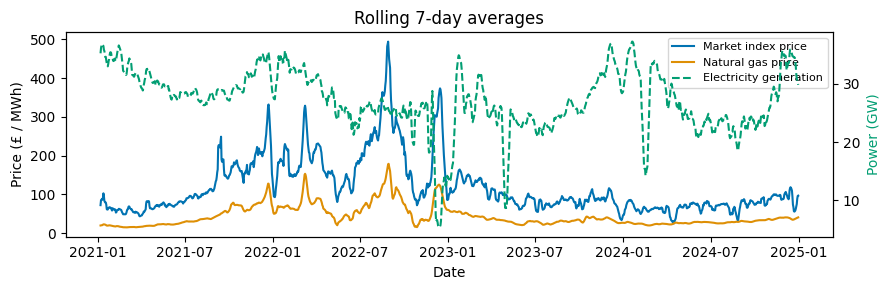

In [163]:
# compute rolling average MIP and NGP
df = df_electricity.groupby('settlementDate')[['marketIndexPrice', 'naturalGasPrice']].mean()
df = df.rolling(window=7).mean()
rolling_avg_MIP = df['marketIndexPrice']
rolling_avg_NGP = df['naturalGasPrice']

# compute rolling average generation
generation_types = ['NUCLEAR', 'GAS', 'WIND', 'INTER', 'BIOMASS', 'SOLAR', 'COAL', 'OIL', 'OTHER']
generation_by_type = df_electricity[generation_types]
df_electricity['generationTotal'] = generation_by_type.sum(axis=1)
daily_generation = df_electricity.groupby('settlementDate')['generationTotal'].mean()
rolling_avg_generation = daily_generation.rolling(window=7).mean()

# create figure
fig, ax = plt.subplots(figsize=(9, 3), layout='tight')
ax.set_title('Rolling 7-day averages')
colors = sns.color_palette("colorblind", 3)

# Plot price data
ax.plot(rolling_avg_MIP.index, rolling_avg_MIP, label='Market index price', color=colors[0])
ax.plot(rolling_avg_NGP.index, rolling_avg_NGP, label='Natural gas price', color=colors[1])
ax.set_xlabel('Date', fontsize=10)
ax.set_ylabel('Price (£ / MWh)', fontsize=10)
ax.legend(fontsize=8)

# plot generation data
ax2 = ax.twinx()
xdata = rolling_avg_generation.index
ydata = rolling_avg_generation / 1000 # rescale to GW
ax2.plot(xdata, ydata, label='Electricity generation', linestyle='--', color=colors[2])
ax2.set_ylabel('Power (GW)', fontsize=10, color=colors[2])

# Combine legends from both axes
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, fontsize=8, loc='best')
plt.show()

*Comments:*

Time-averaged market index prices and natural gas prices appear to be strongly positively correlated, while the correlation between average electricity generation and MIP is less clear on these time scales.

There are some anomalies in the generation data around (i) the end of 2022, (ii) spring 2023, and (ii) the beginning of 2024. Otherwise, there are clearly seasonal trends with more generation during winters and less during summers. These anomalies are likely linked to measurement problems or operational failures on the power markets platform (APX) that the data was collected from. It might be necessary to collect data over a longer time period for model training, but this comes with the potential drawback of including data from the first COVID-19 lockdown periods.

Let's plot MIP, NGP and generation over a shorter time period (first week in October 2023):

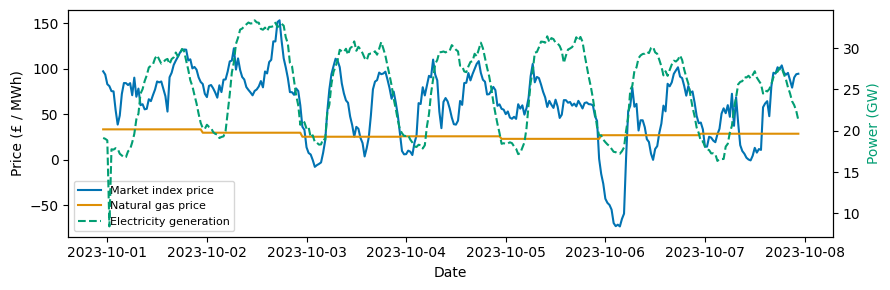

In [162]:
# select smaller date range
start_date = pd.to_datetime("2023-10-01") 
end_date = pd.to_datetime("2023-10-07")
mask = (df_electricity['settlementDate'] >= start_date) & (df_electricity['settlementDate'] <= end_date)
df = df_electricity.loc[mask]
df = df.set_index('startTime')
MIP = df['marketIndexPrice']
NGP = df['naturalGasPrice']
generation = df['generationTotal'] / 1000 # rescale to GW

# create figure
fig, ax = plt.subplots(figsize=(9, 3), layout='tight')
colors = sns.color_palette("colorblind", 3)

# Plot price data
ax.plot(MIP.index, MIP, label='Market index price', color=colors[0])
ax.plot(NGP.index, NGP, label='Natural gas price', color=colors[1])
ax.set_xlabel('Date', fontsize=10)
ax.set_ylabel('Price (£ / MWh)', fontsize=10)
ax.legend(fontsize=8)

# plot generation data
ax2 = ax.twinx()
ax2.plot(generation.index, generation, label='Electricity generation', linestyle='--', color=colors[2])
ax2.set_ylabel('Power (GW)', fontsize=10, color=colors[2])

# Combine legends from both axes
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, fontsize=8, loc='best')
plt.show()

*Comments:* 

It seems that short term fluctuations in price are positively correlated with total electricity generation.

Plot demand with the total generation data:

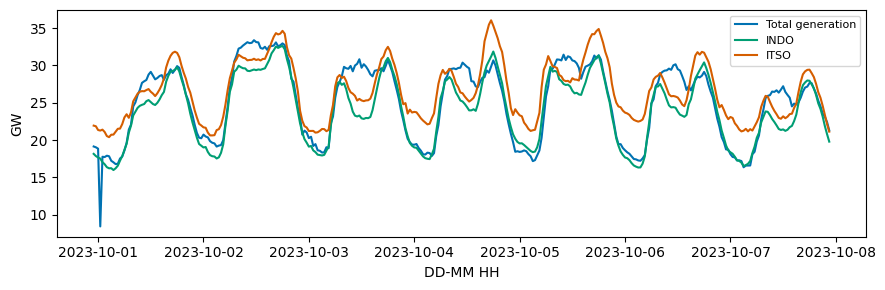

In [161]:
fig, ax = plt.subplots(figsize=(9, 3), layout='tight')
ax.plot(time, generation_by_type.sum(axis=1) / 1000, label='Total generation')
ax.plot(time, df_elec_filtered['INDO']/ 1000, label='INDO')
ax.plot(time, df_elec_filtered['ITSO'] / 1000, label='ITSO')
ax.legend(fontsize=8)
ax.set_xlabel('DD-MM HH', fontsize=10)
ax.set_ylabel('GW', fontsize=10)
plt.show()

*Comments:* 

Unsure how to interpret the plot above.

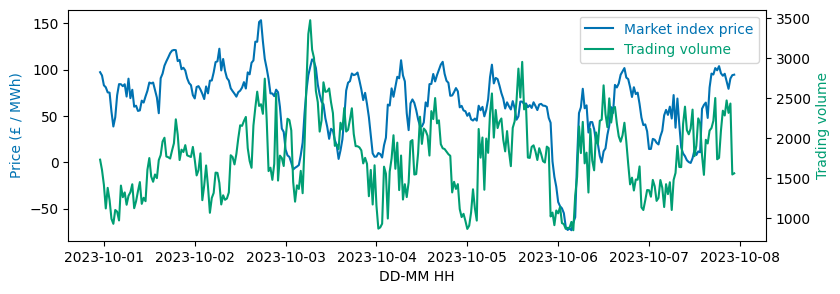

In [160]:
# Plot market index price and trading volume:
from mpl_toolkits.axes_grid1 import host_subplot

plt.figure(figsize=(9,3))
host = host_subplot(111)
par = host.twinx()

host.set_xlabel("DD-MM HH", fontsize=10)
host.set_ylabel("Price (£ / MWh)", fontsize=10)
par.set_ylabel("Trading volume", fontsize=10)

p1, = host.plot(df_elec_filtered['startTime'], df_elec_filtered['marketIndexPrice'], label="Market index price")
p2, = par.plot(df_elec_filtered['startTime'], df_elec_filtered['marketIndexTradingVolume'], label="Trading volume")

host.legend(labelcolor="linecolor")

host.yaxis.label.set_color(p1.get_color())
par.yaxis.label.set_color(p2.get_color())

plt.show()

*Comments:*

There seems to be daily fluctuations in both price and trading volume with peaks during the day and troughs during the night. The market price index (MIP) and the trading volume appear to be positively correlated. 

### 1.3 Electricity generation

Let's break down electricity generation sources by plotting the rolling seven-day averages:

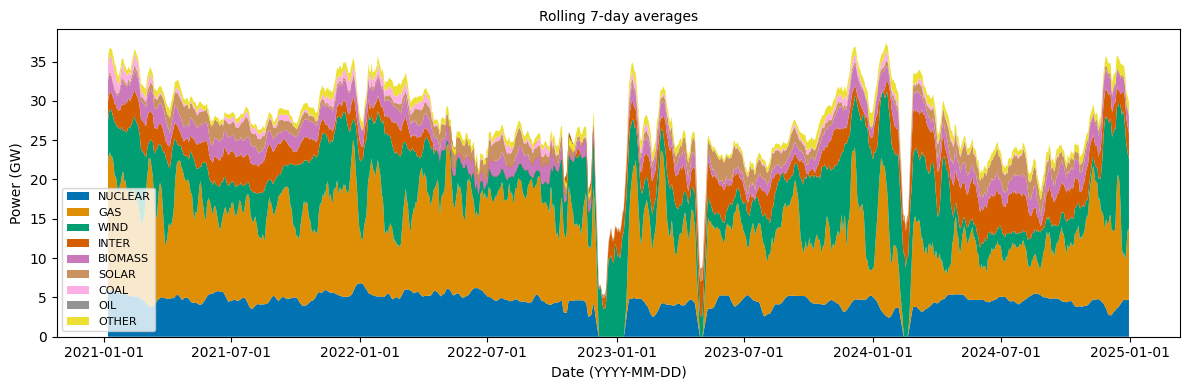

In [165]:
daily_generation_by_type = df_electricity.groupby('settlementDate')[generation_types].mean()
rolling_avg = daily_generation_by_type.rolling(window=7).mean()

fig, ax = plt.subplots(figsize=(12,4), layout='tight')
ax.set_title('Rolling 7-day averages', fontsize=10)
colors = sns.color_palette("colorblind", len(generation_types))
xdata = rolling_avg.index
ydata = [rolling_avg[gt] / 1000 for gt in generation_types]
ax.stackplot(xdata, ydata, labels=generation_types, colors=colors)
ax.legend(fontsize=8, loc='best')
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date (YYYY-MM-DD)', fontsize=10)
ax.set_ylabel('Power (GW)', fontsize=10)
plt.show()

Plot electricity generation breakdown for the first week in October 2023:

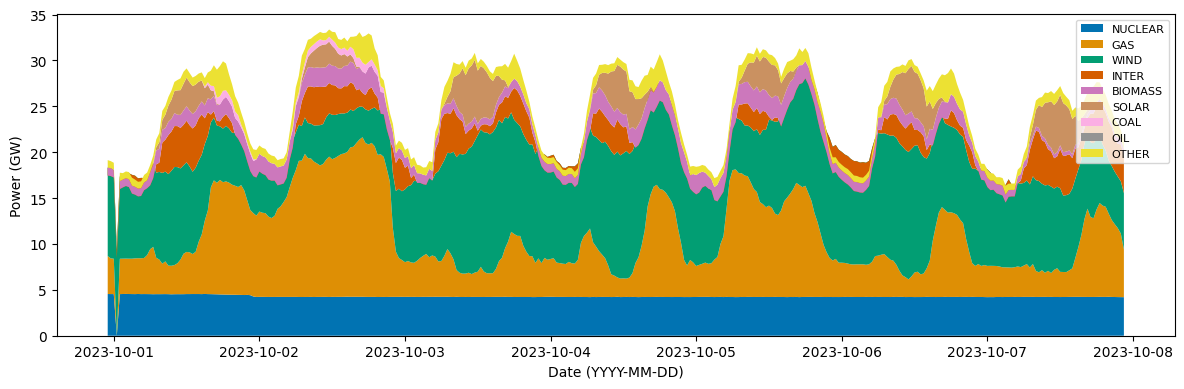

In [166]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn-v0_8-colorblind')

from matplotlib.ticker import MaxNLocator
from matplotlib.dates import DateFormatter
import datetime

# select smaller date range for plotting
start_date = pd.to_datetime("2023-10-01") 
end_date = pd.to_datetime("2023-10-07")
mask = (df_electricity['settlementDate'] >= start_date) & (df_electricity['settlementDate'] <= end_date)
df_elec_filtered = df_electricity.loc[mask].copy()

time = df_elec_filtered['startTime']
generation_by_type = df_elec_filtered[generation_types]

fig, ax = plt.subplots(figsize=(12, 4), layout='tight')
colors = sns.color_palette("colorblind", len(generation_types))
ax.stackplot(time, [generation_by_type[gt] / 1000 for gt in generation_types], labels=generation_types, colors=colors)
ax.legend(fontsize=8, loc='upper right')
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date (YYYY-MM-DD)', fontsize=10)
ax.set_ylabel('Power (GW)', fontsize=10)
plt.show()

*Comments:*

- Nuclear, gas and wind make up the majority of the energy generation
- Nuclear generation is very stable
- There are large, daily fluctuations in energy generation
- Energy from interconnectors is mostly positive, indicating that imports are larger than exports
- Solar generation coincides with peak hours
- Oil generation is neglibible

In [95]:
# drop oil generation from data
df_electricity.drop(columns='OIL', inplace=True)

### 1.4 Weather

Plot temperature and wind speed:

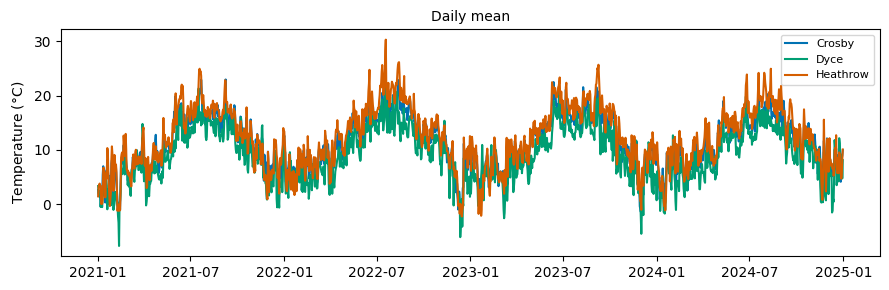

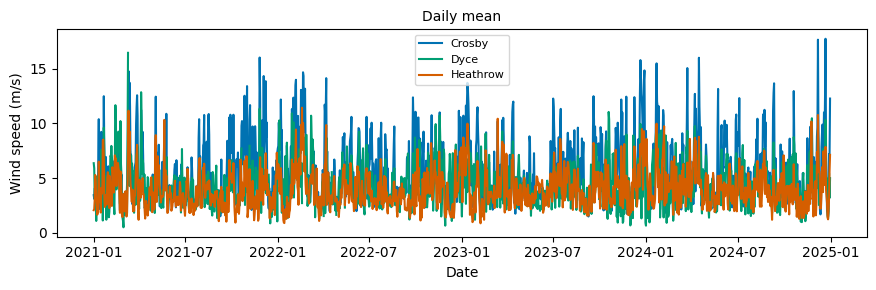

In [ ]:
locations = ['Heathrow', 'Crosby', 'Dyce']

# Temperature plot with daily means
fig, ax = plt.subplots(figsize=(9, 3), layout='tight')
for location, group in df_weather.groupby('location'):
    # Compute daily mean
    daily_mean = group.groupby(group['ob_time'].dt.date)['air_temperature'].mean()
    ax.plot(daily_mean.index, daily_mean.values, label=location)
ax.legend(fontsize=8)
ax.set_title("Daily mean", fontsize=10)
ax.set_ylabel('Temperature ($\\degree \\mathrm{C}$)', fontsize=10)
ax.set_title("Daily mean", fontsize=10)
plt.show()

# Wind speed plot with daily means
fig, ax = plt.subplots(figsize=(9, 3), layout='tight')
for location, group in df_weather.groupby('location'):
    # Compute daily mean
    daily_mean = group.groupby(group['ob_time'].dt.date)['wind_speed'].mean()
    ax.plot(daily_mean.index, daily_mean.values, label=location)
ax.legend(fontsize=8)
ax.set_xlabel('Date', fontsize=10)
ax.set_ylabel('Wind speed (m/s)', fontsize=10)
ax.set_title("Daily mean", fontsize=10)
plt.show()

*Comments:*

Temperature follows a seasonal pattern, while wind speed appears to vary a lot around a constant value.

Let's smoothen the weather data by plotting rolling 7-day averages:

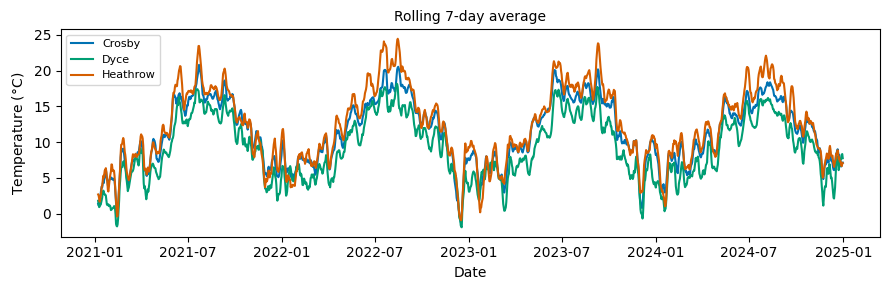

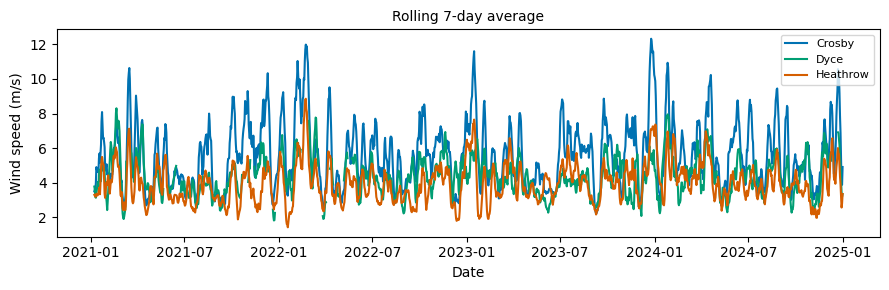

In [183]:
# Temperature plot
fig, ax = plt.subplots(figsize=(9, 3), layout='tight')
for location, group in df_weather.groupby('location'):
    daily_mean = group.groupby(group['ob_time'].dt.date)['air_temperature'].mean()
    rolling_avg = daily_mean.rolling(window=7).mean()
    ax.plot(rolling_avg.index, rolling_avg.values, label=location)
ax.legend(fontsize=8)
ax.set_xlabel('Date', fontsize=10)
ax.set_ylabel('Temperature ($\\degree \\mathrm{C}$)', fontsize=10)
ax.set_title("Rolling 7-day average", fontsize=10)
plt.show()

# Wind speed plot
fig, ax = plt.subplots(figsize=(9, 3), layout='tight')
for location, group in df_weather.groupby('location'):
    daily_mean = group.groupby(group['ob_time'].dt.date)['wind_speed'].mean()
    rolling_avg = daily_mean.rolling(window=7).mean()
    ax.plot(rolling_avg.index, rolling_avg.values, label=location)
ax.legend(fontsize=8)
ax.set_xlabel('Date', fontsize=10)
ax.set_ylabel('Wind speed (m/s)', fontsize=10)
ax.set_title("Rolling 7-day average", fontsize=10)
plt.show()

Plot temperature and wind speed over a shorter period:

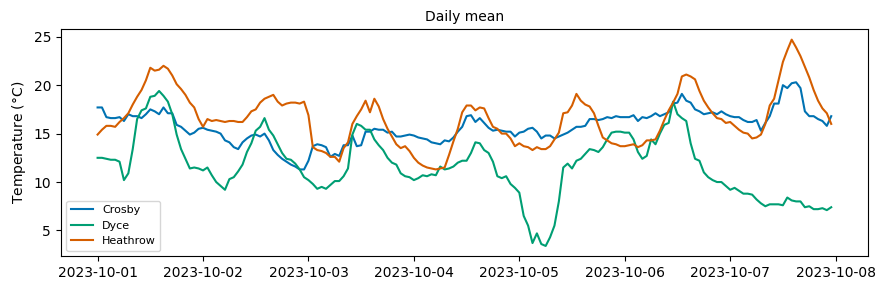

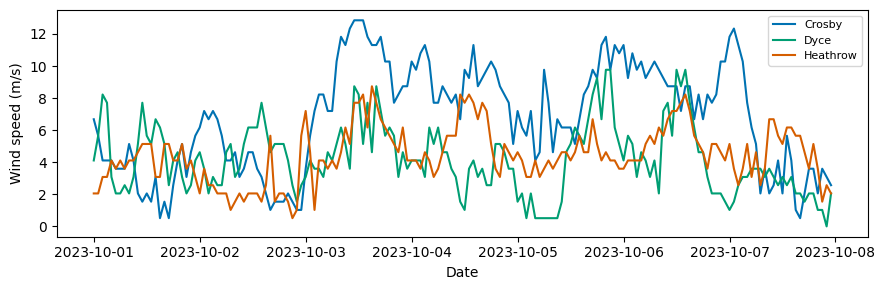

In [184]:
start_date = pd.to_datetime("2023-10-01")
end_date = pd.to_datetime("2023-10-08")
mask = (df_weather['ob_time'] >= start_date) & (df_weather['ob_time'] < end_date)
df = df_weather.loc[mask].copy()

fig, ax = plt.subplots(figsize=(9, 3), layout='tight')
for location, group in df.groupby('location'):
    ax.plot(group['ob_time'], group['air_temperature'], label=location)
ax.legend(fontsize=8)
ax.set_title("Daily mean", fontsize=10)
ax.set_ylabel('Temperature ($\\degree \\mathrm{C}$)', fontsize=10)
plt.show()

# Wind speed plot with daily means
fig, ax = plt.subplots(figsize=(9, 3), layout='tight')
for location, group in df.groupby('location'):
    ax.plot(group['ob_time'], group['wind_speed'], label=location)
ax.legend(fontsize=8)
ax.set_xlabel('Date', fontsize=10)
ax.set_ylabel('Wind speed (m/s)', fontsize=10)
plt.show()

*Comments:*

There appear to be daily fluctuations in both temperature and speed. 

Plot temperature and wind speeds with market index prices:

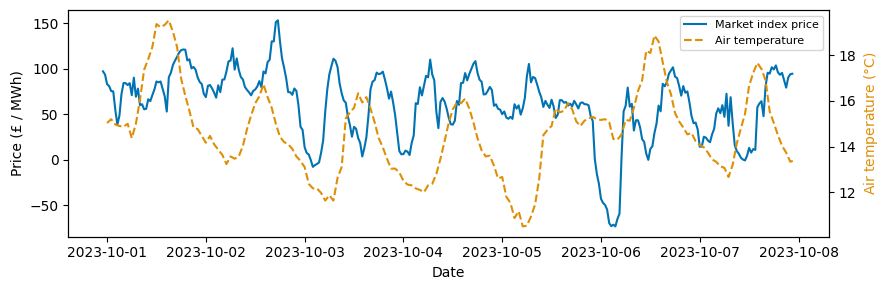

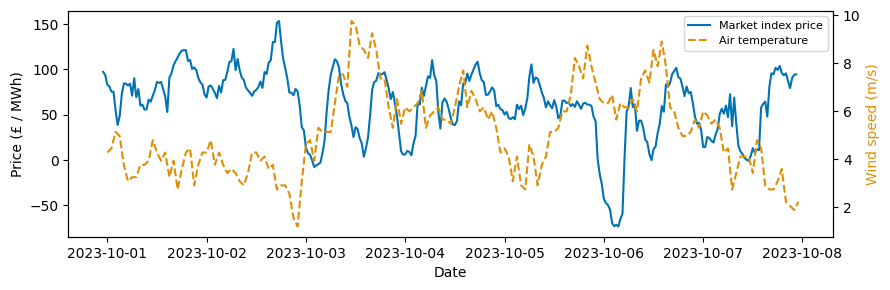

In [187]:
# select date range
start_date = pd.to_datetime("2023-10-01")
end_date = pd.to_datetime("2023-10-08")

# get price data
mask = (df_electricity['settlementDate'] >= start_date) & (df_electricity['settlementDate'] < end_date)
df = df_electricity.loc[mask]
df = df.set_index('startTime')
MIP = df['marketIndexPrice']

# get weather data and average over locations
mask = (df_weather['ob_time'] >= start_date) & (df_weather['ob_time'] < end_date)
df = df_weather.loc[mask].copy()
air_temp = df.groupby(df['ob_time'])['air_temperature'].mean()
wind_speed = df.groupby(df['ob_time'])['wind_speed'].mean()


# create figure 1
fig, ax = plt.subplots(figsize=(9, 3), layout='tight')
colors = sns.color_palette("colorblind", 3)

# plot price
ax.plot(MIP.index, MIP, label='Market index price', color=colors[0])
ax.set_xlabel('Date', fontsize=10)
ax.set_ylabel('Price (£ / MWh)', fontsize=10)
ax.legend(fontsize=8)

# plot air temperature
ax2 = ax.twinx()
ax2.plot(air_temp.index, air_temp.values, label='Air temperature', linestyle='--', color=colors[1])
ax2.set_ylabel('Air temperature ($\\degree \\mathrm{C}$)', fontsize=10, color=colors[1])

# Combine legends from both axes
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, fontsize=8, loc='best')
plt.show()


# create figure 2
fig, ax = plt.subplots(figsize=(9, 3), layout='tight')
colors = sns.color_palette("colorblind", 3)

# plot price
ax.plot(MIP.index, MIP, label='Market index price', color=colors[0])
ax.set_xlabel('Date', fontsize=10)
ax.set_ylabel('Price (£ / MWh)', fontsize=10)
ax.legend(fontsize=8)

# plot wind speed
ax2 = ax.twinx()
ax2.plot(wind_speed.index, wind_speed.values, label='Air temperature', linestyle='--', color=colors[1])
ax2.set_ylabel('Wind speed (m/s)', fontsize=10, color=colors[1])

# Combine legends from both axes
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, fontsize=8, loc='best')
plt.show()

## 2. Correlations

## 3. Hypothesis Formulation

We hypothesise the following:

**Supply hypothesis:** Gas prices, wind, and solar radiation are the main supply-side drivers of electricity prices.

**Demand hypothesis:** Temperature and time variables are the main demand-side drivers of electricity prices.